
Processing: jana_nerudová.parquet
Loops: 10, Open-ended: 21


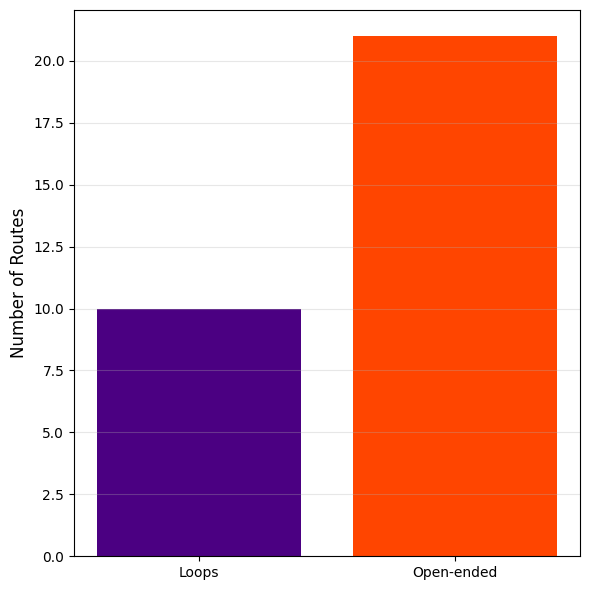


Processing: brad_stahlman.parquet
Loops: 40, Open-ended: 4


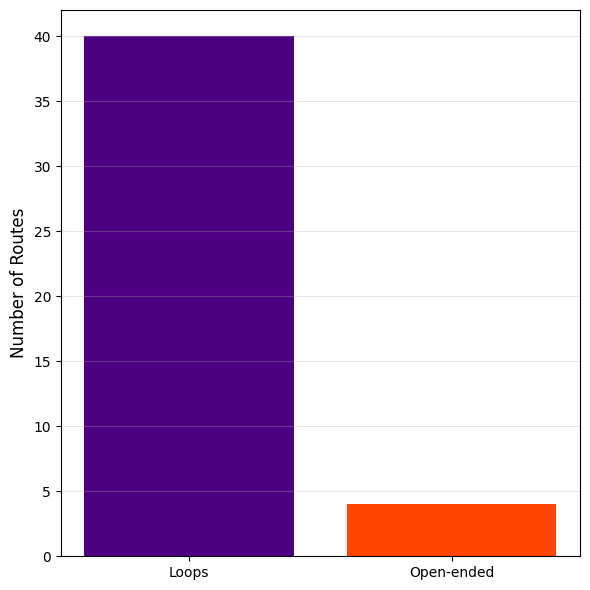


Processing: brian_watson.parquet
Loops: 0, Open-ended: 10


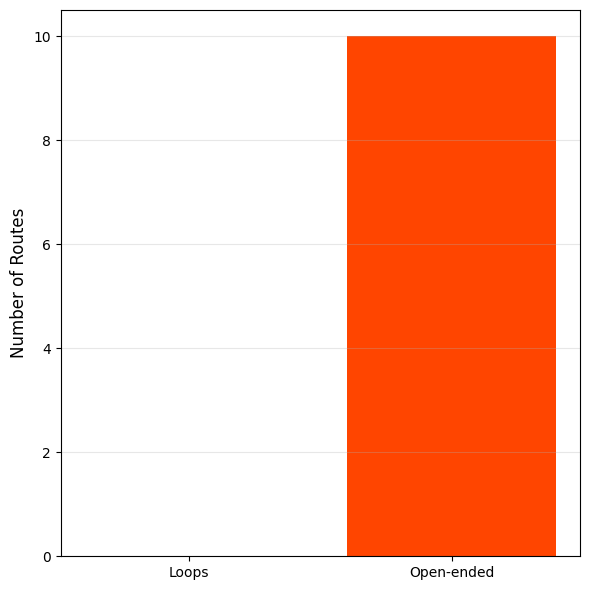


Processing: dennis_lindsay.parquet
No valid routes in dennis_lindsay.parquet

Processing: john_goss.parquet
Loops: 8, Open-ended: 1


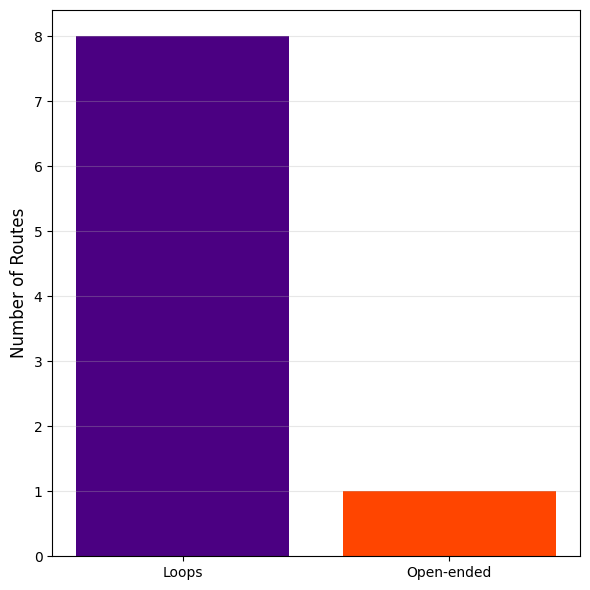


Processing: issy_nielson.parquet
Loops: 45, Open-ended: 15


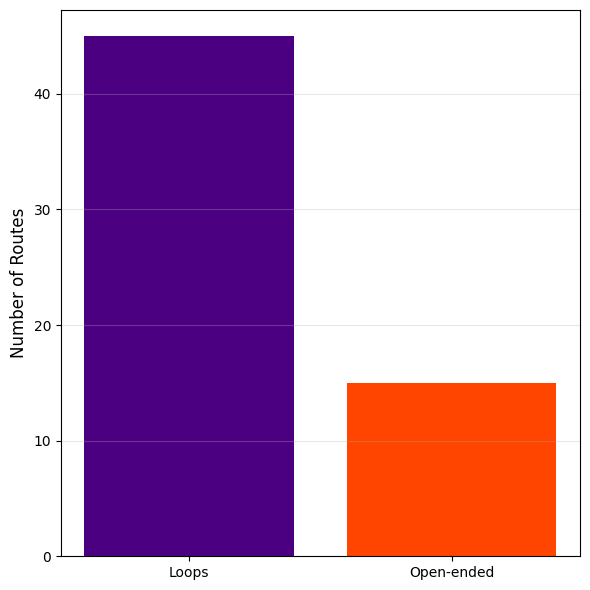


Processing: stefan_hornke.parquet
Loops: 0, Open-ended: 15


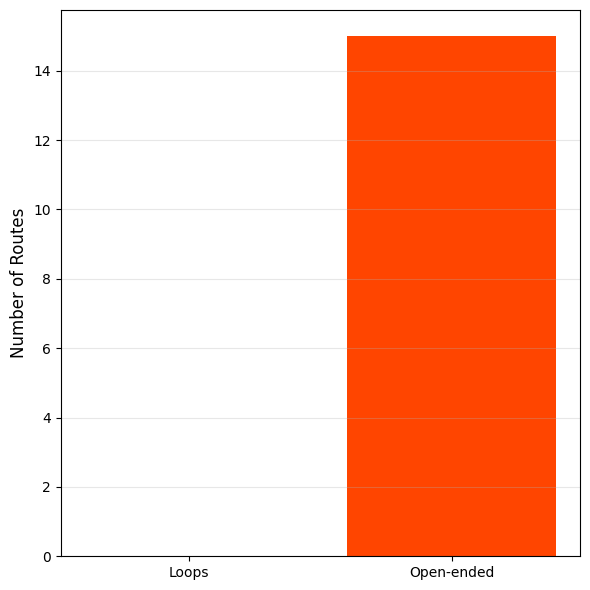


Processing: todd_baum.parquet
Loops: 18, Open-ended: 0


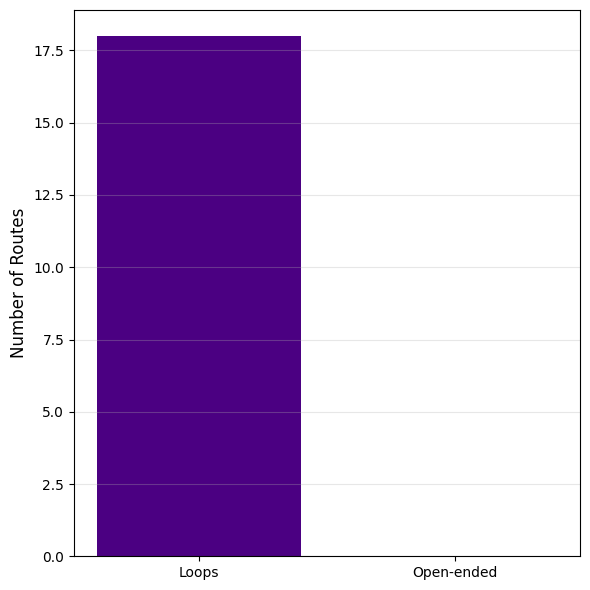


Processing: rhiannon_settles.parquet
No valid routes in rhiannon_settles.parquet

Processing: george_bella.parquet
No valid routes in george_bella.parquet

Processing: mollie_melton.parquet
Loops: 68, Open-ended: 3


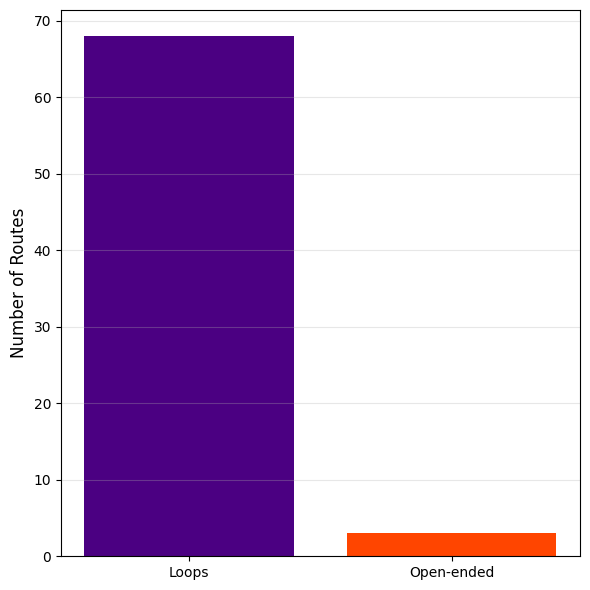


Processing: geraud_mousnier.parquet
Loops: 13, Open-ended: 1


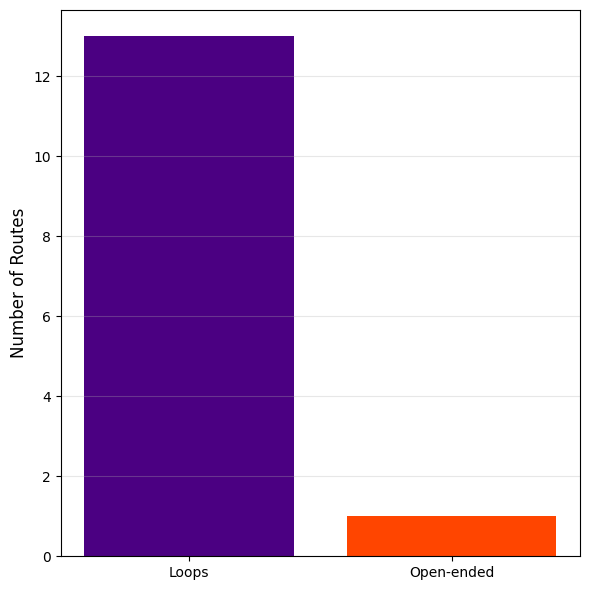


Processing: david_bunting.parquet
No valid routes in david_bunting.parquet

Processing: huggi_bayanbyamba.parquet
Loops: 33, Open-ended: 5


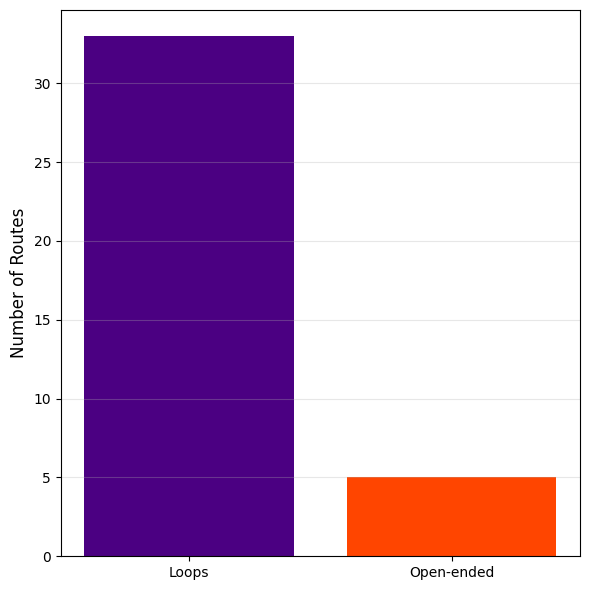


Processing: noah_white.parquet
Loops: 34, Open-ended: 4


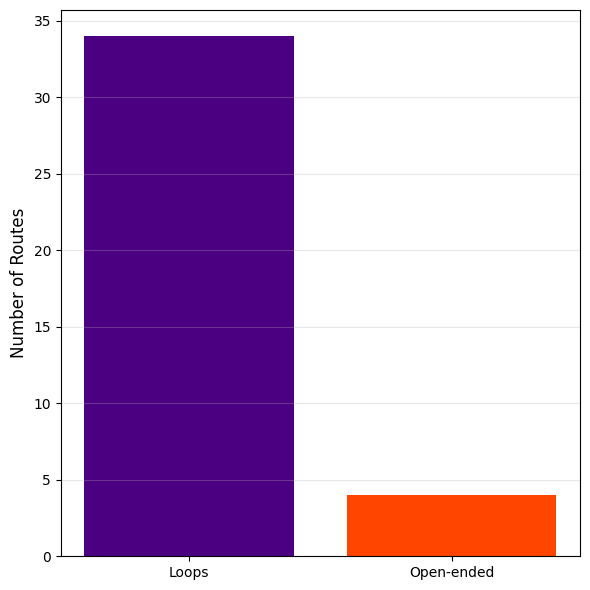


Processing: eileen_cohen.parquet
Loops: 44, Open-ended: 3


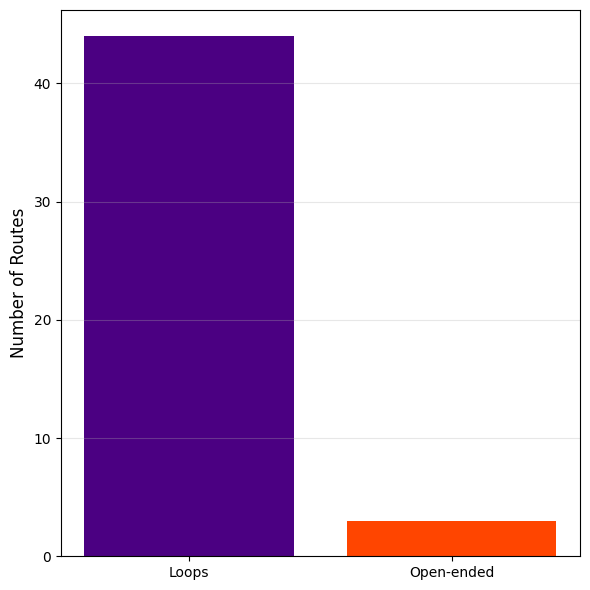


Processing: andre_tannemann.parquet
Loops: 6, Open-ended: 12


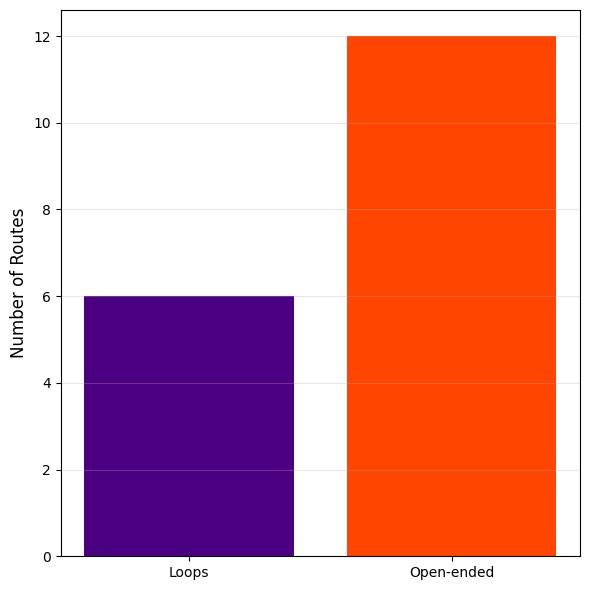


Processing: ken_kirsch.parquet
Loops: 73, Open-ended: 2


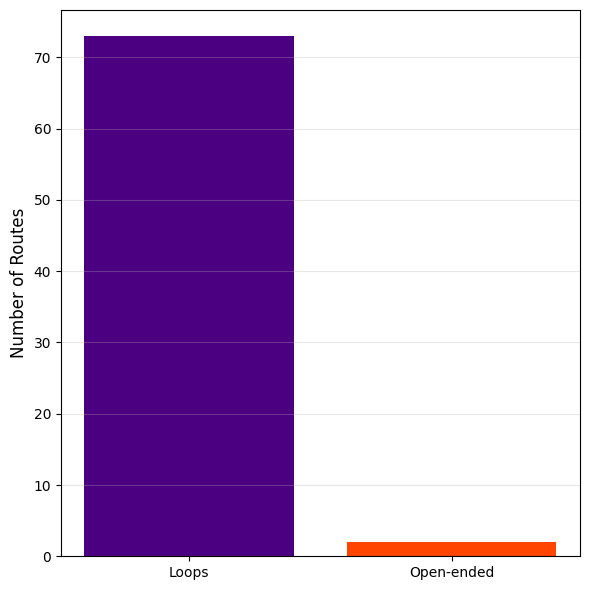


Processing: stuart_foster.parquet
Loops: 14, Open-ended: 7


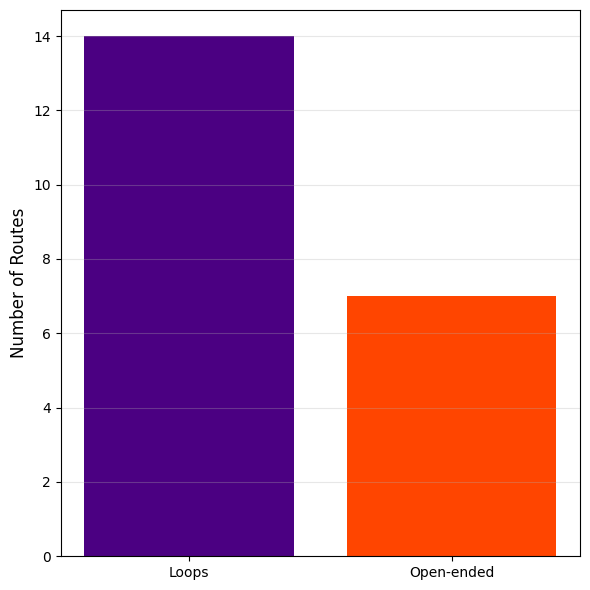


Processing: steve_schohn.parquet
Loops: 12, Open-ended: 0


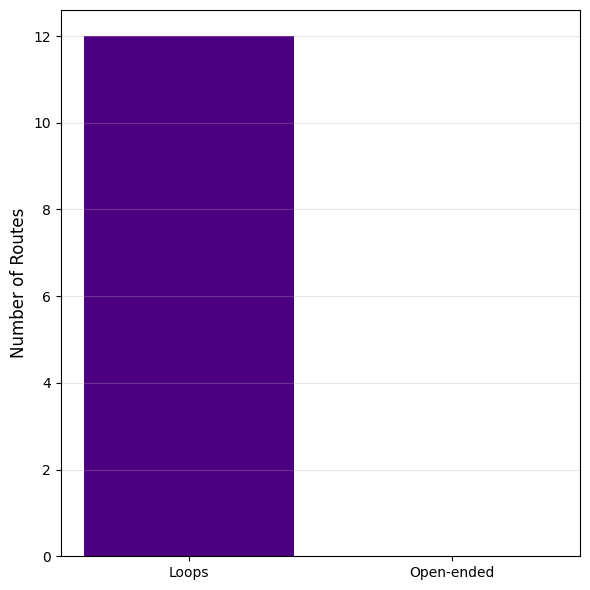


Processing: jen_cadenhead.parquet
Loops: 23, Open-ended: 5


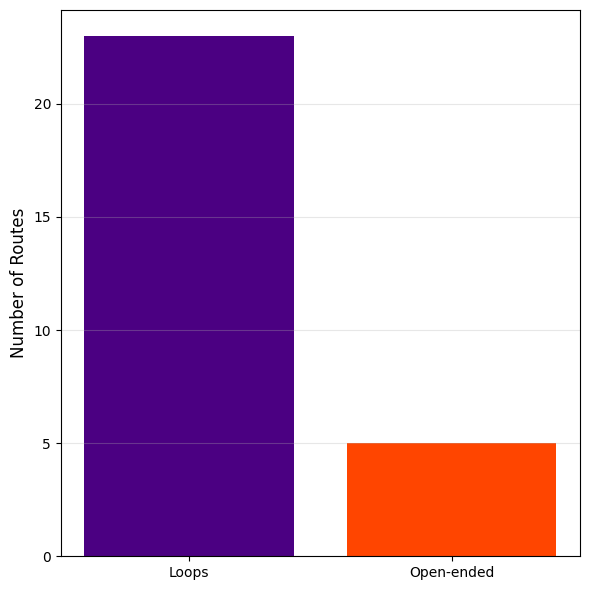


Processing: amy_pizer.parquet
Loops: 85, Open-ended: 2


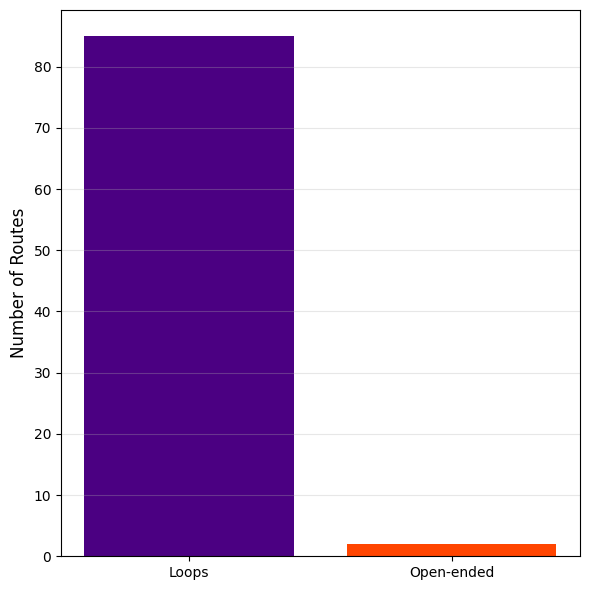


Processing: andrew_mccrory.parquet
Loops: 9, Open-ended: 18


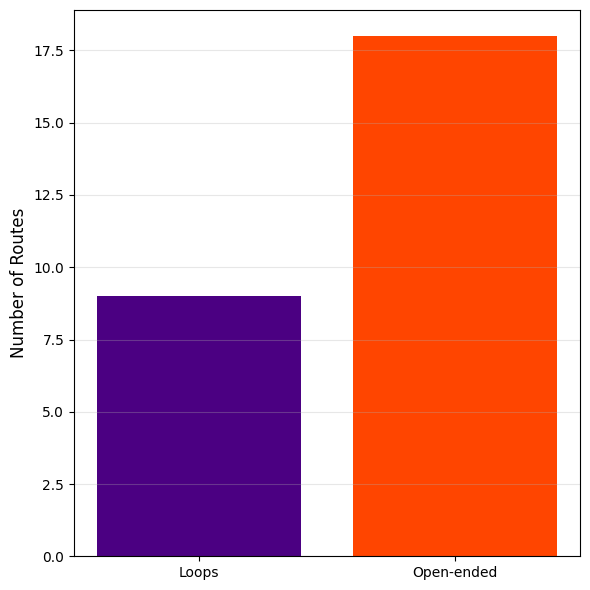


Processing: john_thayer.parquet
No valid routes in john_thayer.parquet

Processing: mark_bull.parquet
Loops: 7, Open-ended: 6


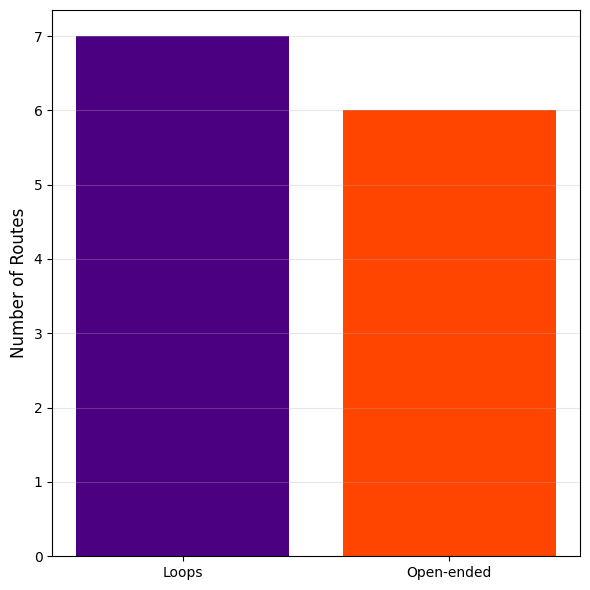


Processing: tom_weaver.parquet
Loops: 28, Open-ended: 5


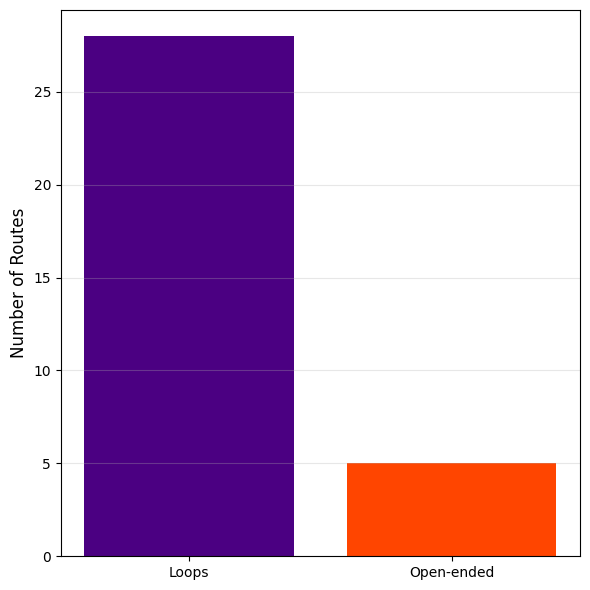


Processing: chris_calimano.parquet
Loops: 13, Open-ended: 3


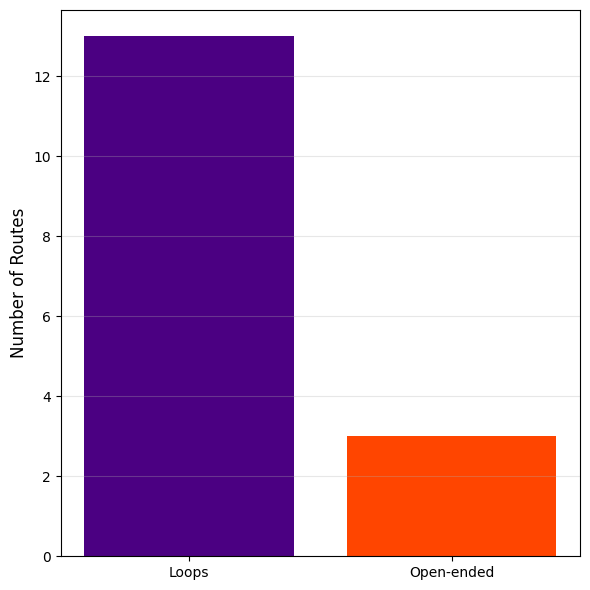


Processing: bethany_pribila.parquet
Loops: 29, Open-ended: 13


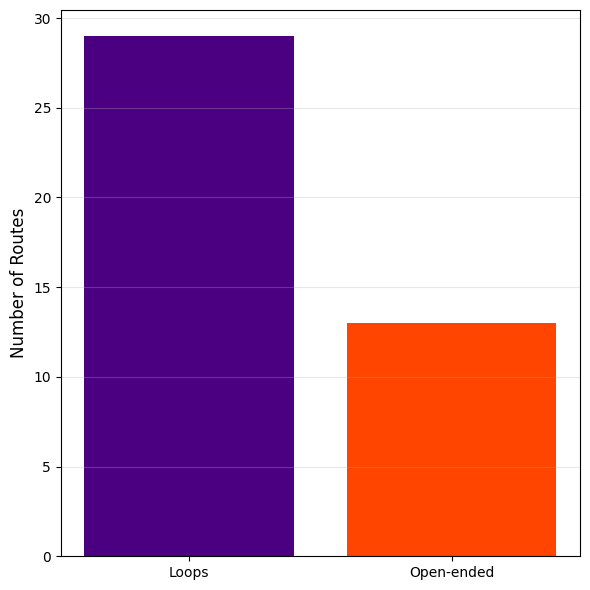


Processing: zeph_brand.parquet
Loops: 22, Open-ended: 2


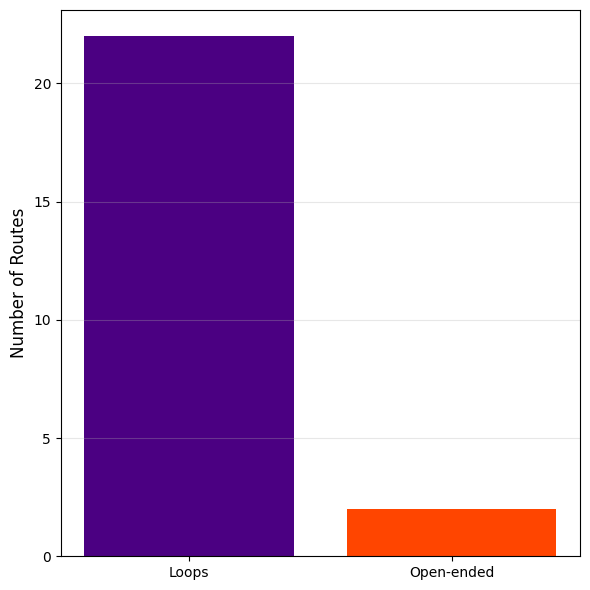


Processing: vera_stetinova.parquet
Loops: 6, Open-ended: 8


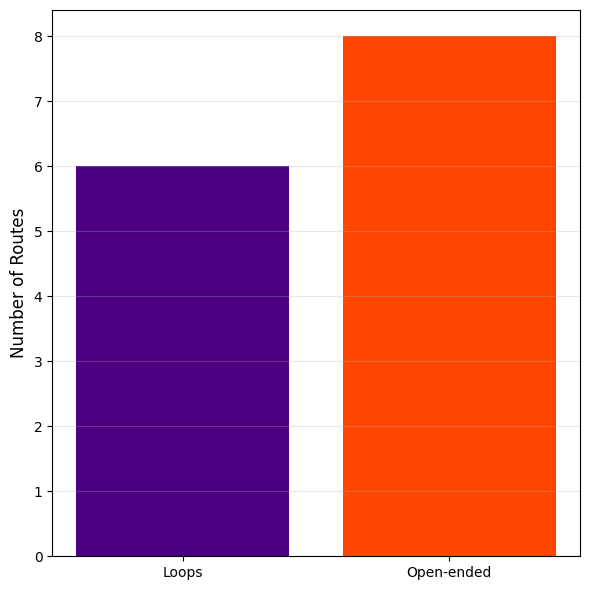


Processing: mathias_göbel.parquet
Loops: 9, Open-ended: 20


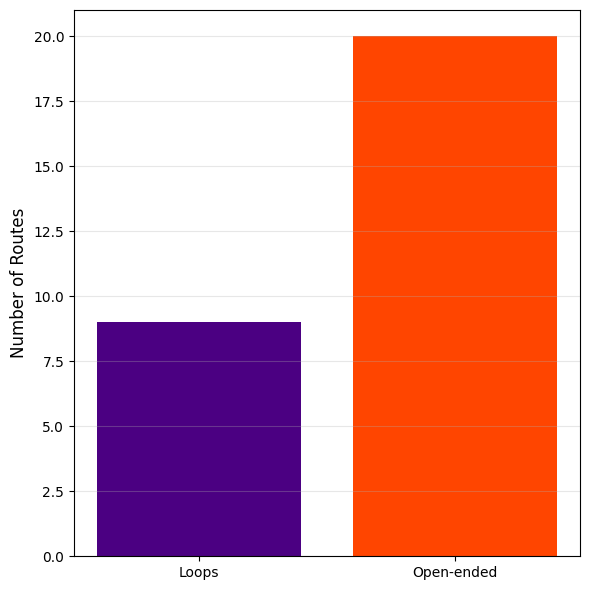


Processing: monique_barrant.parquet
No valid routes in monique_barrant.parquet

Processing: w_ford_graham.parquet
Loops: 15, Open-ended: 19


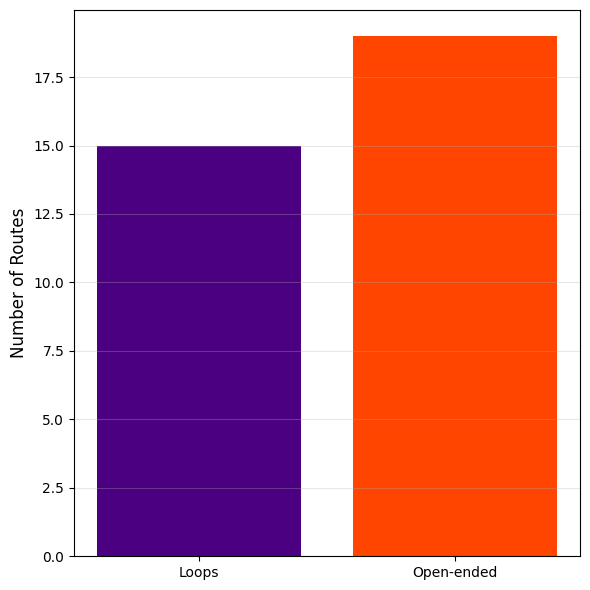


Processing: bryan_twomey.parquet
Loops: 7, Open-ended: 2


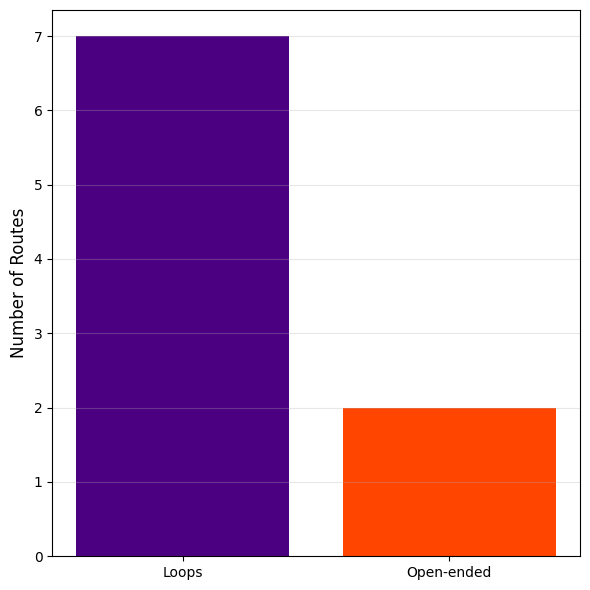


Processing: angela_chong.parquet
Loops: 18, Open-ended: 7


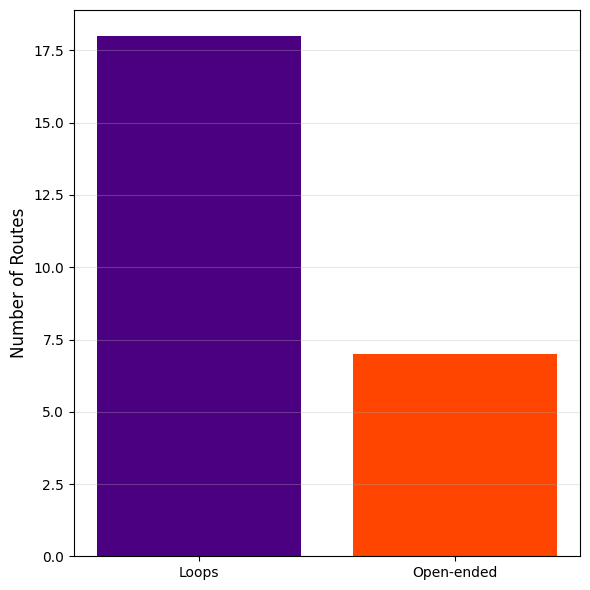


Processing: kevin_dockemeyer.parquet
Loops: 12, Open-ended: 0


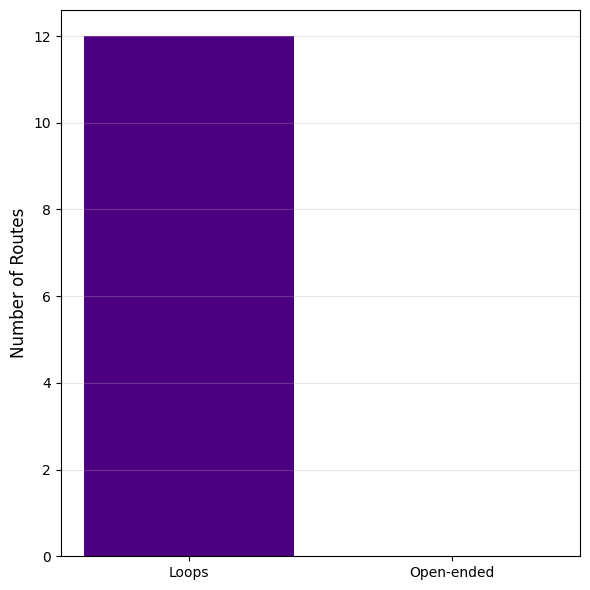


Processing: jeffrey_ruiz.parquet
Loops: 17, Open-ended: 2


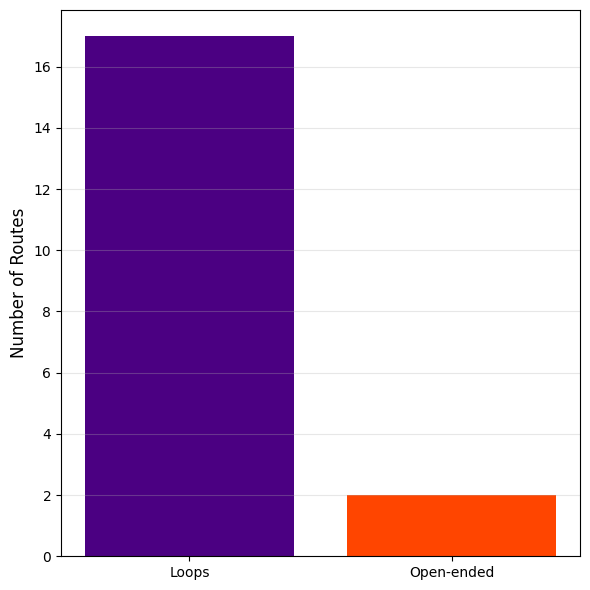


Processing: marc_sanderson.parquet
Loops: 12, Open-ended: 7


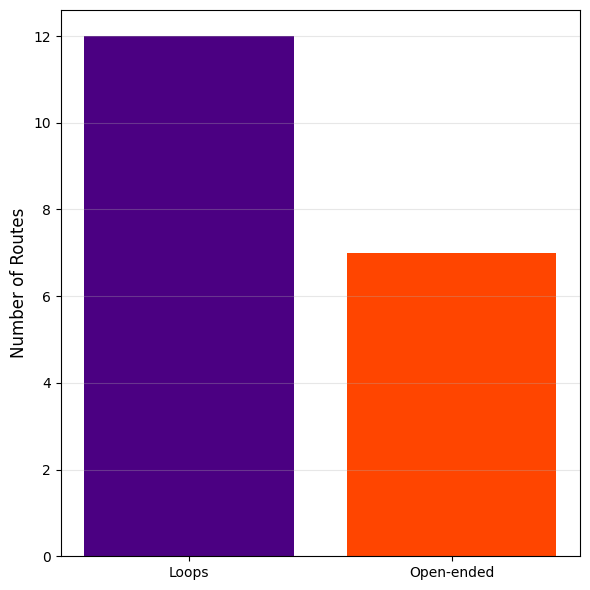


Processing: caryn_lubetsky.parquet
Loops: 43, Open-ended: 21


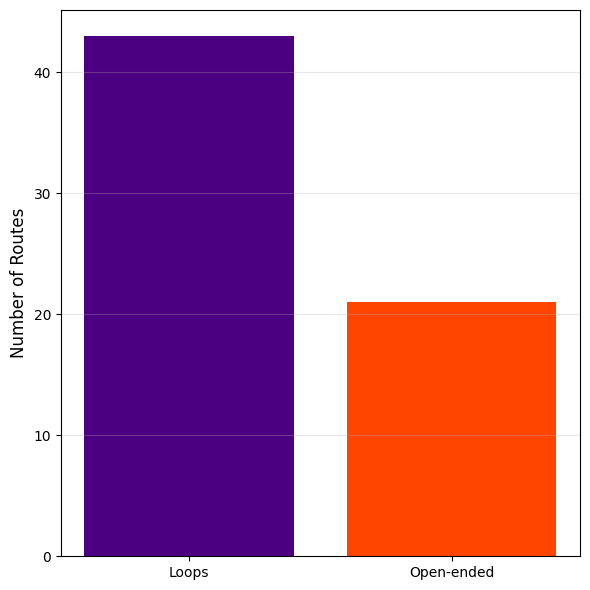


Processing: rhiannon_bramer.parquet
Loops: 44, Open-ended: 6


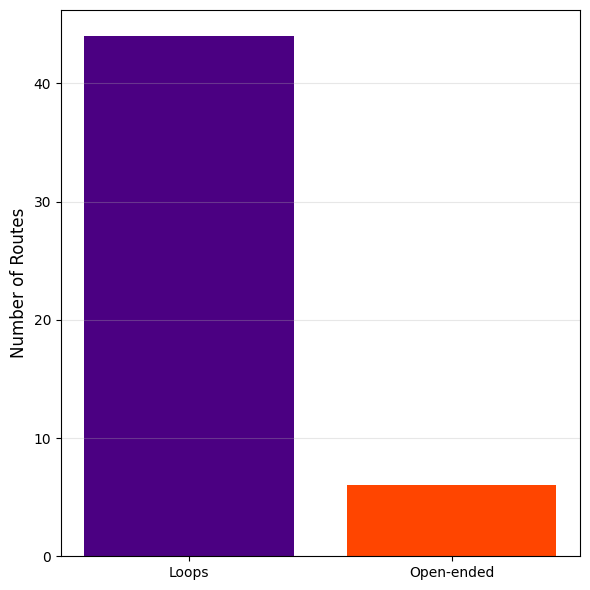


Processing: dani_grigsby.parquet
Loops: 23, Open-ended: 6


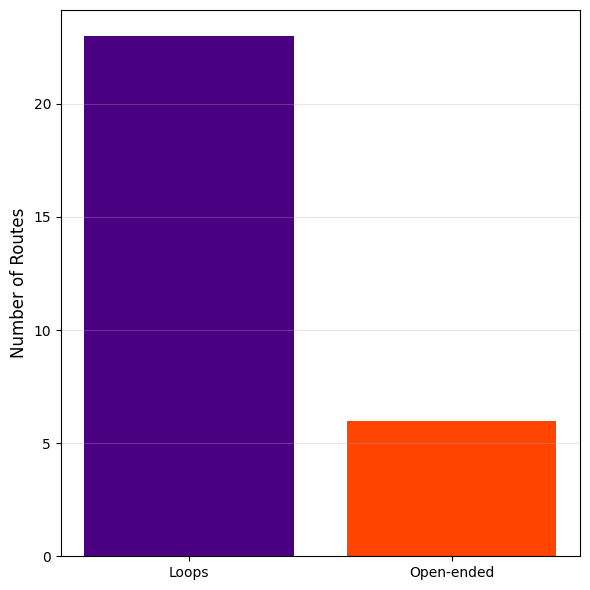


Processing: dave_krupski.parquet
Loops: 14, Open-ended: 10


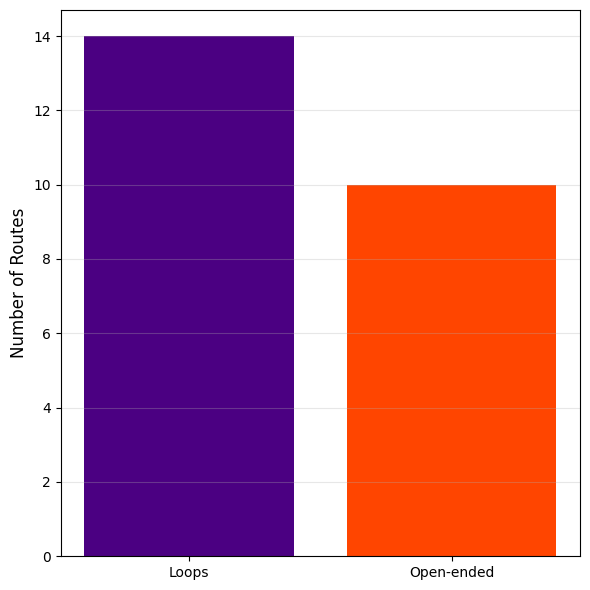


Processing: evgeny_arbatov.parquet
Loops: 22, Open-ended: 1


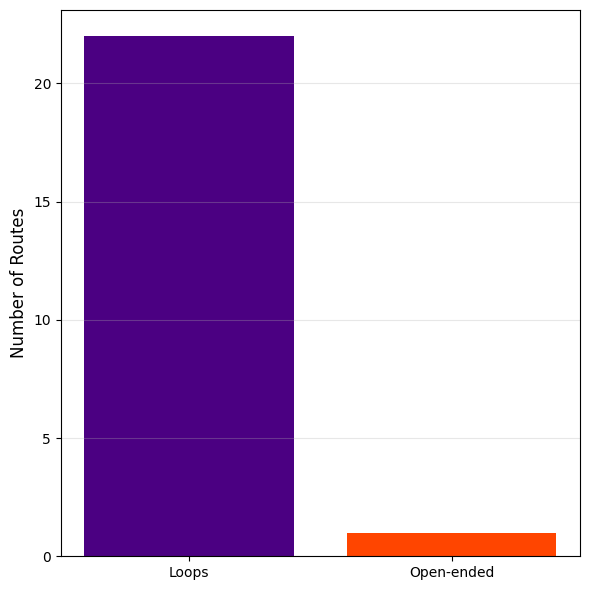


Processing: sean_richard.parquet
Loops: 16, Open-ended: 5


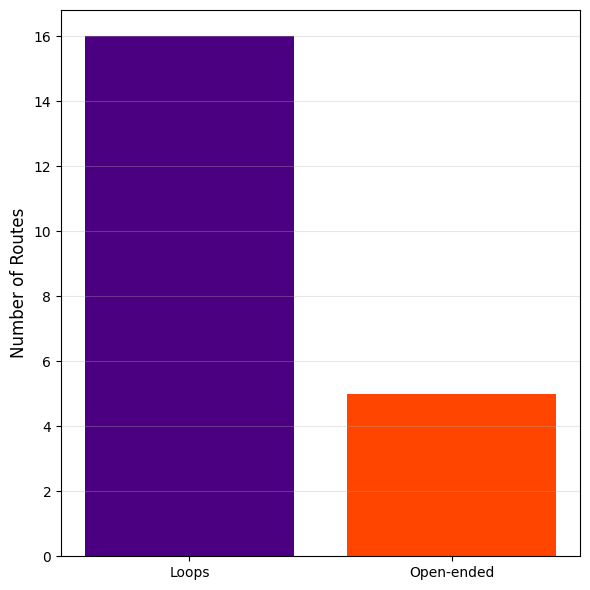


Processing: andreas_stemberger.parquet
Loops: 16, Open-ended: 4


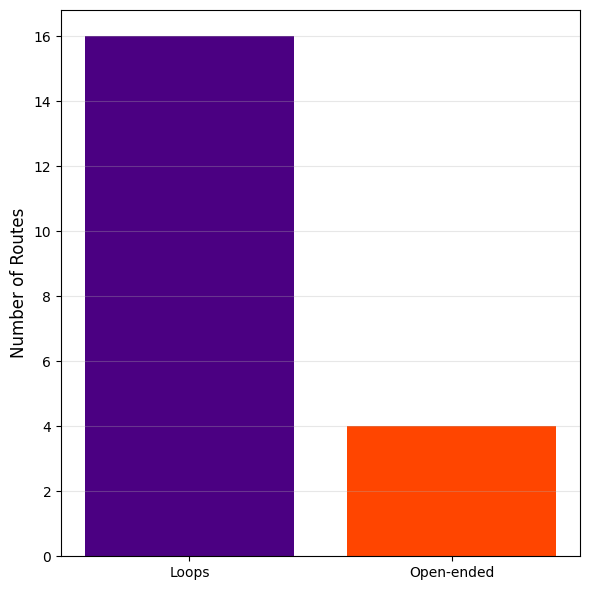


Processing: simen_holvik.parquet
Loops: 0, Open-ended: 3


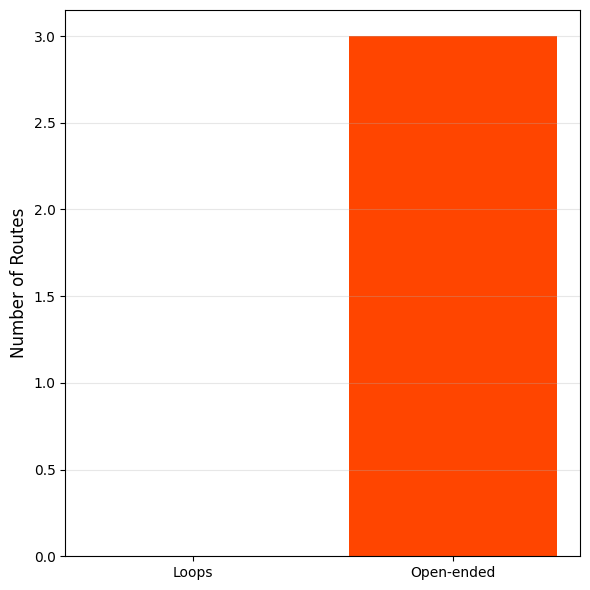


Processing: madoka_spence.parquet
Loops: 35, Open-ended: 3


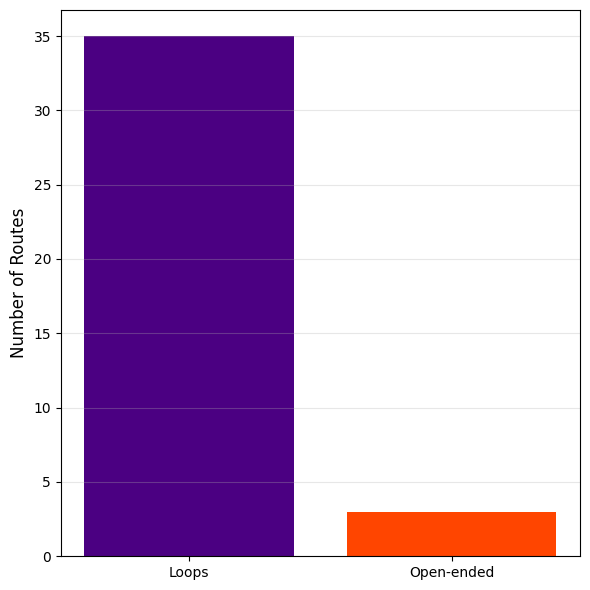


Processing: rebecca_oliver.parquet
No valid routes in rebecca_oliver.parquet

Processing: kevin_koncilja.parquet
Loops: 24, Open-ended: 18


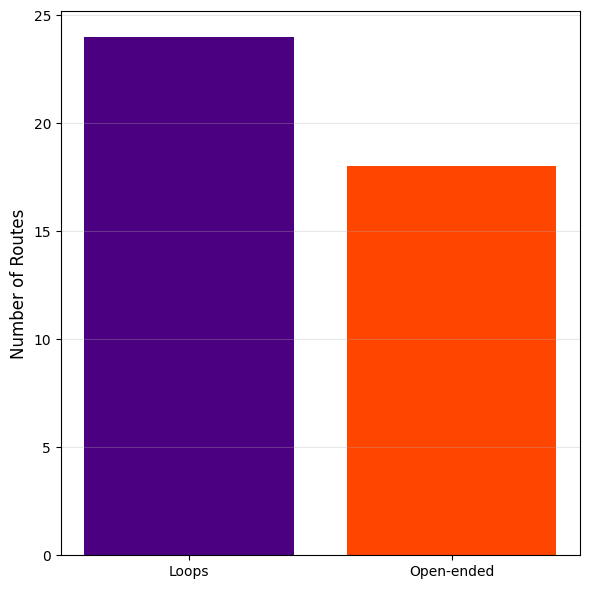


Processing: michael_postulka.parquet
Loops: 27, Open-ended: 15


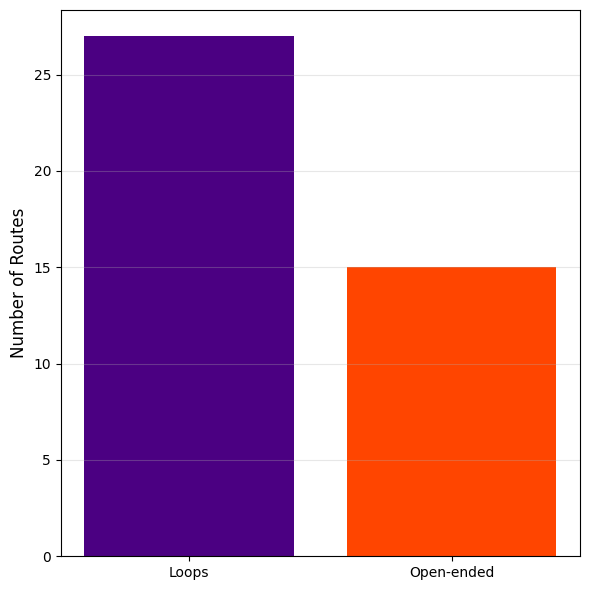


Processing: anonymous_participant.parquet
Loops: 26, Open-ended: 1


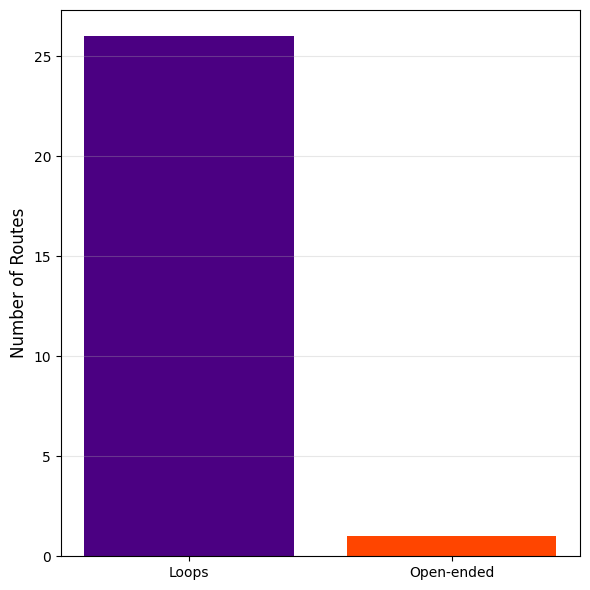


Processing: jessica_de_la_cruz.parquet
Loops: 38, Open-ended: 0


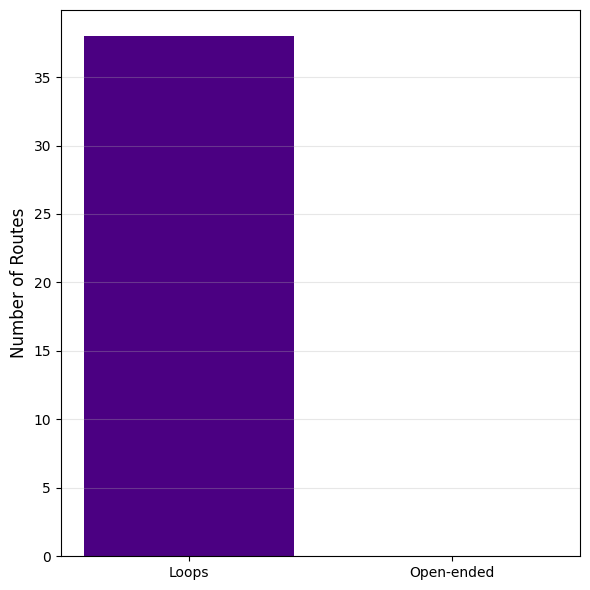


Processing: angela_hawley.parquet
Loops: 21, Open-ended: 0


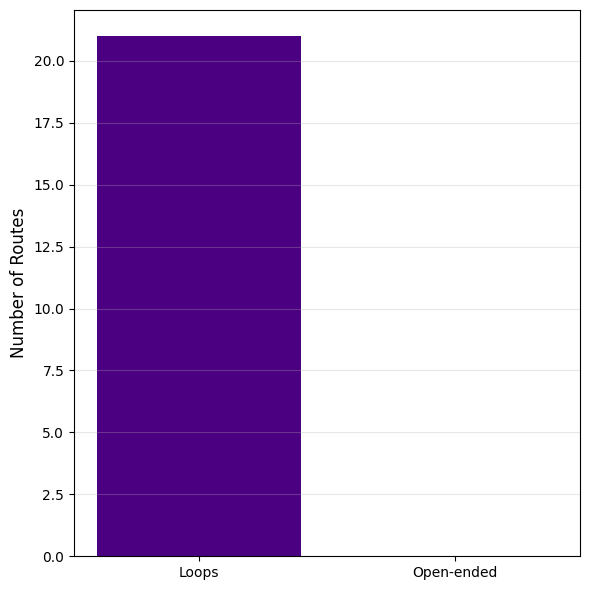


Processing: tim_walter_reudelsdorff.parquet
Loops: 2, Open-ended: 3


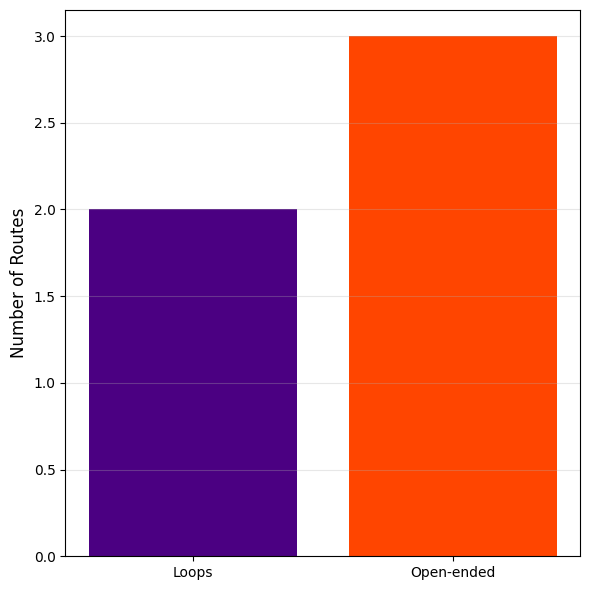


Processing: emily_lyons.parquet
Loops: 3, Open-ended: 2


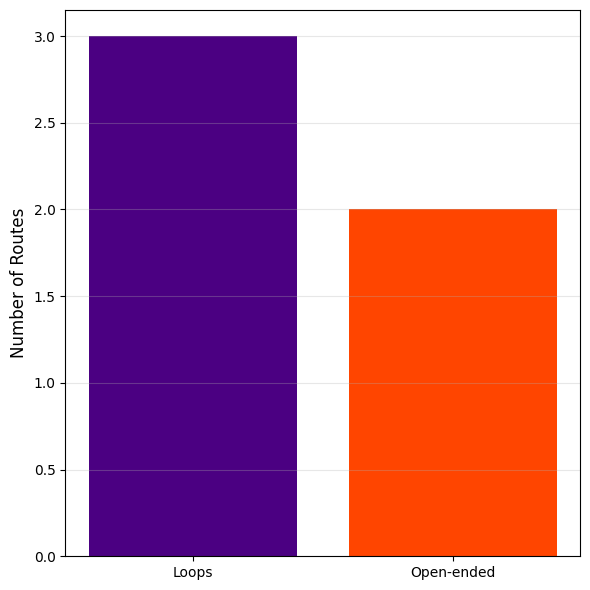


Processing: aner_cosme.parquet
Loops: 37, Open-ended: 8


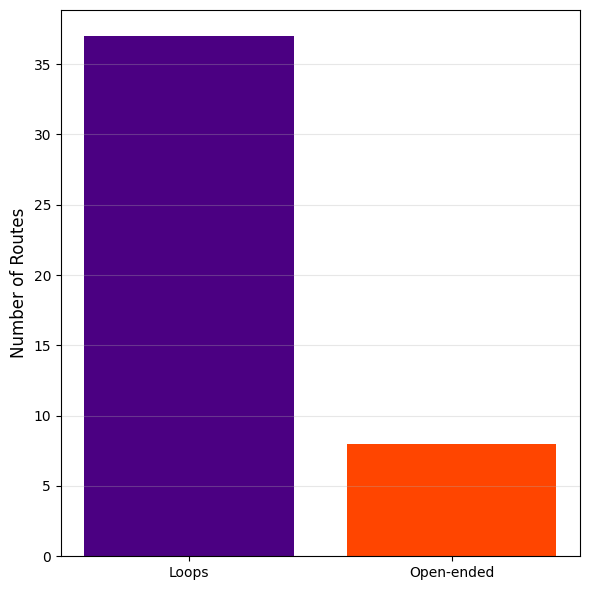


Processing: stephen_mick.parquet
Loops: 13, Open-ended: 4


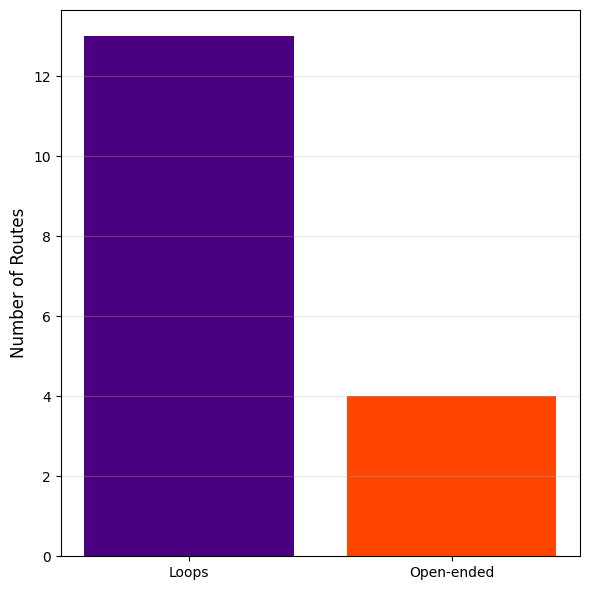


Processing: jeffrey_jordan.parquet
Loops: 25, Open-ended: 5


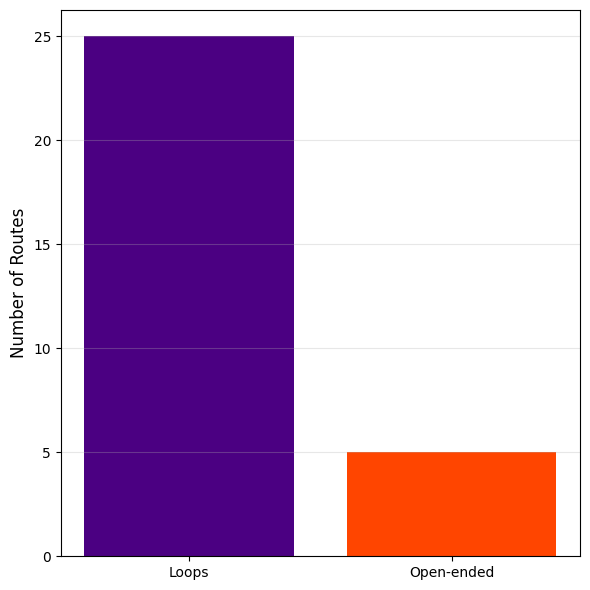


Processing: athanasia_tolidou.parquet
Loops: 12, Open-ended: 17


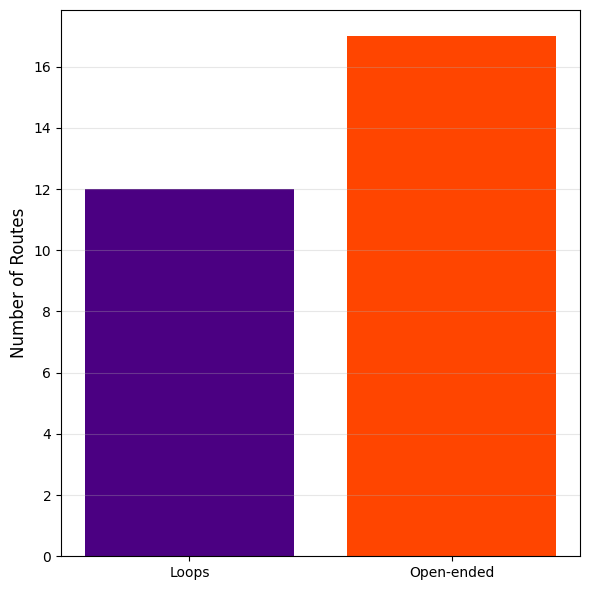


Processing: christian_nogens.parquet
Loops: 6, Open-ended: 14


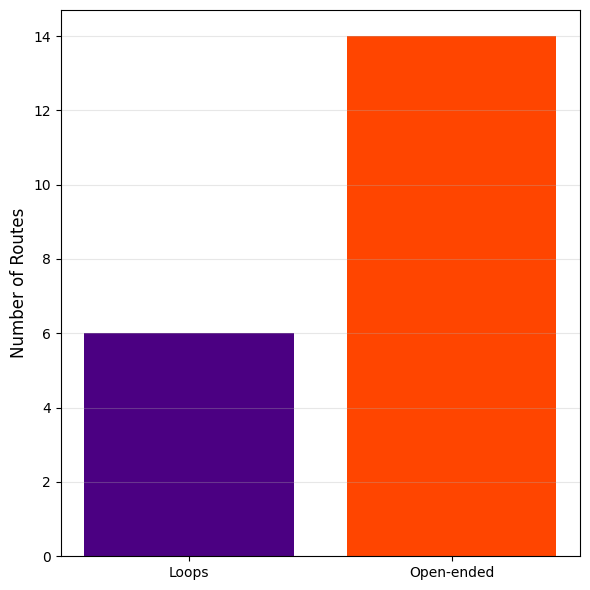


Processing: david_van_den_bossche.parquet
Loops: 9, Open-ended: 12


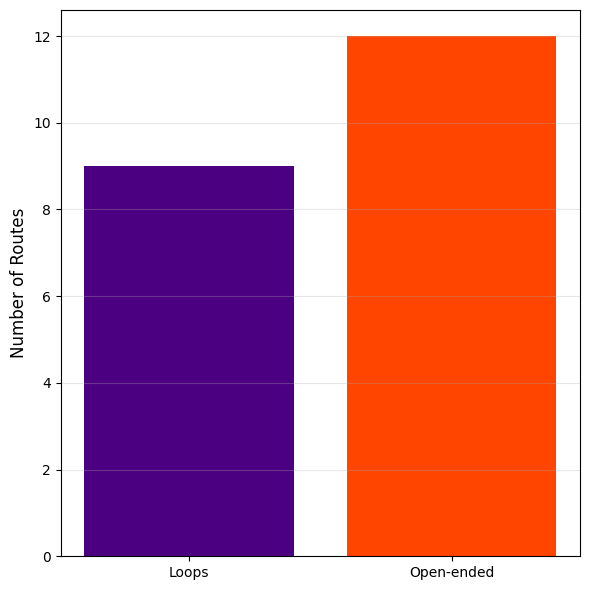

In [4]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import os
from geopy.distance import geodesic

# --- Configuration ---
content_dir = '/content'
parquet_files = [f for f in os.listdir(content_dir) if f.endswith('.parquet')]

# Colors for plotting
route_colors = {
    "loop": "#4B0082",    # Indigo
    "open": "#FF4500"     # Orange Red
}

# --- Helper functions ---
def extract_route_coordinates(geometry):
    if geometry is None or geometry.is_empty:
        return None
    return [(coord[1], coord[0]) for coord in geometry.coords]

# --- Process each parquet file ---
for parquet_file in parquet_files:
    print(f"\nProcessing: {parquet_file}")
    file_path = os.path.join(content_dir, parquet_file)
    gdf = gpd.read_parquet(file_path)

    start_stop_matches = []

    for geom in gdf.geometry:
        coords = extract_route_coordinates(geom)
        if coords is None or len(coords) < 2:
            continue

        # Check if start and stop are within 500 meters
        start = coords[0]
        stop = coords[-1]
        same_location = geodesic(start, stop).meters <= 500
        start_stop_matches.append(same_location)

    if not start_stop_matches:
        print(f"No valid routes in {parquet_file}")
        continue

    # Count loops and open-ended
    n_loops = sum(start_stop_matches)
    n_open = len(start_stop_matches) - n_loops
    print(f"Loops: {n_loops}, Open-ended: {n_open}")

    # --- Plot histogram ---
    plt.figure(figsize=(6, 6))
    plt.bar(["Loops", "Open-ended"], [n_loops, n_open], color=[route_colors["loop"], route_colors["open"]])
    plt.ylabel("Number of Routes", fontsize=12)
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.savefig(f"/content/loops_vs_open_routes_{parquet_file[:-8]}.png", dpi=150)
    plt.show()
    plt.close()
